Analyze how facrec classifier bias varies on the original dataset vs. the matched dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from tqdm import tqdm
from collections import OrderedDict
from config import *
from style import cb, cr, cg, cp
import data
import util
import viz
import matching

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

# print([k for k in os.listdir(DIR_PROCESSED_MISC) if '14_' in k])
k_group = 'gender'
matches = pd.read_pickle(oj(DIR_PROCESSED, 'matches_gender_num=1200_facerecthresh=0.6.pkl'))
NUM_MATCHES = 500
matches = matches[:NUM_MATCHES]

# facial-rec dist benchmarking

In [2]:
dists_facial = data.get_dists('facial')
dists_facial2 = data.get_dists('facenet_vgg2')
dists_facial3 = data.get_dists('facenet_casia')

**calculate original dists**

In [28]:
THRESH = 0.6
def hist_dists(r, density=True):
    plt.hist(1 - np.array(r[0]), density=density, cumulative=True)
    plt.hist(1 - np.array(r[1]), density=density, alpha=0.5, cumulative=True)
    plt.yscale('log')
    plt.xlabel('Facial similarity (dllib) for image\npairs with the same identity')
    plt.ylabel('Density')
    plt.axvline(1 - THRESH, linestyle='--', color='gray', alpha=1)
#     plt.legend(title=attr.capitalize(), loc='lower right', framealpha=1)
    plt.show()
    
def calc_dists_orig(df, dists):
    '''Calculate distances for pairs in original data
    '''
    ds_orig = { 0: [], 1: [] }
    for val in ds_orig.keys():
        d = df[df['count_with_this_id'] > 1]
        d = d[d[k_group] == val]
        ids = sorted(d.id.unique())
        for i in tqdm(ids):
            r2 = d[d.id == i][:2].index.values.astype(int) - 1 # first 2 ims
            dist = dists[r2[0], r2[1]]
            if not dist == 1e3:
                ds_orig[val].append(dist)
    ds_orig = {k: np.array(ds_orig[k]) for k in ds_orig.keys()}
    return ds_orig


def calc_dists_matches(df, dists): 
    '''Calculate distances for pairs after matching
    '''
    r = {}
    accs = {}
    for i in [0, 1]:
        idxs_match = matches[k_group + '_' + str(i)].values
        idxs_ref = matches[k_group + '_' + str(i) + '_ref'].values
        r[i] = np.array([dists[r, c]
                for (r, c) in zip(idxs_match, idxs_ref)
                if not dists[r, c] == 1e3])
        accs[i] = np.array(r[i]) < THRESH
    return r

In [29]:
dist_names = ['dlib', 'facenet (vggface2)', 'facenet (casia)']
ds_orig_list = {}
accs_orig_list = {}
ds_matches_list = {}
accs_matches_list = {}
for k, dists in zip(dist_names, [dists_facial, dists_facial2, dists_facial3]):
    # original dists
    ds_orig_list[k] = calc_dists_orig(df, dists)
    accs_orig_list[k] = {kk: ds_orig_list[k][kk] < THRESH for kk in ds_orig_list[k].keys()}
    # hist_dists(ds_orig)

    # new dists
    ds_matches_list[k] = calc_dists_matches(df, dists)
    accs_matches_list[k] = {kk: ds_matches_list[k][kk] < THRESH for kk in ds_matches_list[k].keys()}
    # hist_dists(r)

100%|██████████| 1881/1881 [00:01<00:00, 1174.84it/s]


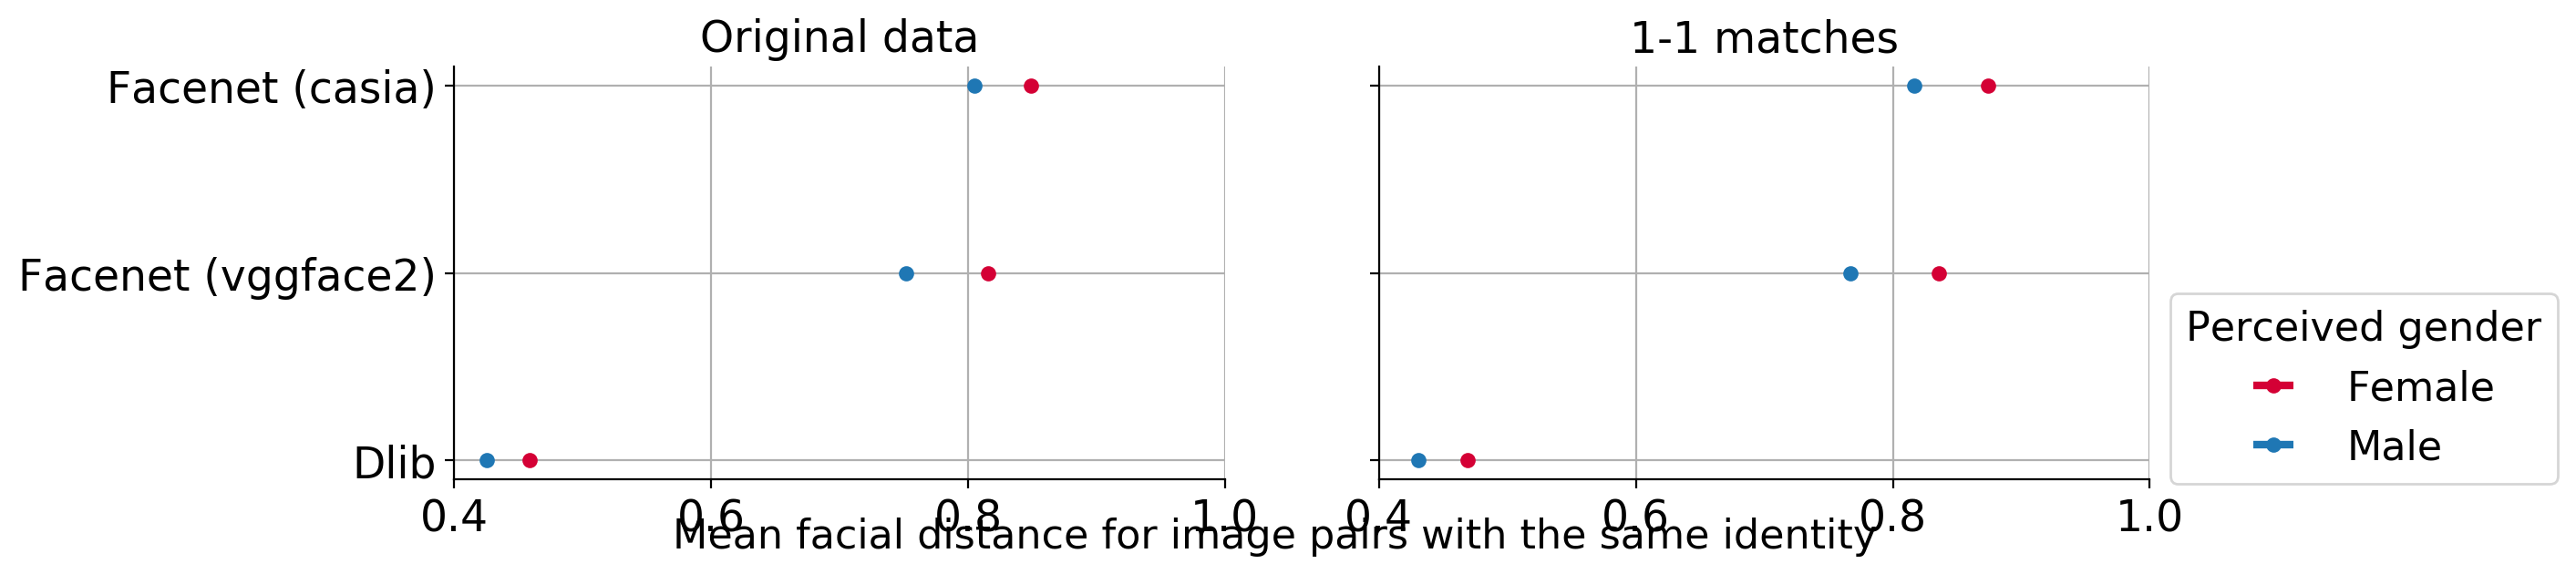

In [30]:
R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(12, 3))
colors = [cr, cb]
titles = ['Original data', '1-1 matches']
for i, d in enumerate([ds_orig_list, ds_matches_list]):
# for i, d in enumerate([accs_orig_list, accs_matches_list]):    
    g0 = {k: d[k][0] for k in d.keys()}
    g1 = {k: d[k][1] for k in d}
    
    ax = plt.subplot(R, C, i + 1)
    args = viz.plot_subgroup_means(g0, g1, ks=np.array(dist_names),
                                        CI='wilson',
                                        ticklabels=i == 0, colors=colors)
    plt.xlim((0.4, 1))
    plt.title(titles[i])
fig.text(0.5, 0, 'Mean facial distance for image pairs with the same identity', ha='center')
        
plt.legend(bbox_to_anchor=(1, 0.5), title='Perceived gender')
# util.savefig('dists_matching')
plt.show()

2635
500


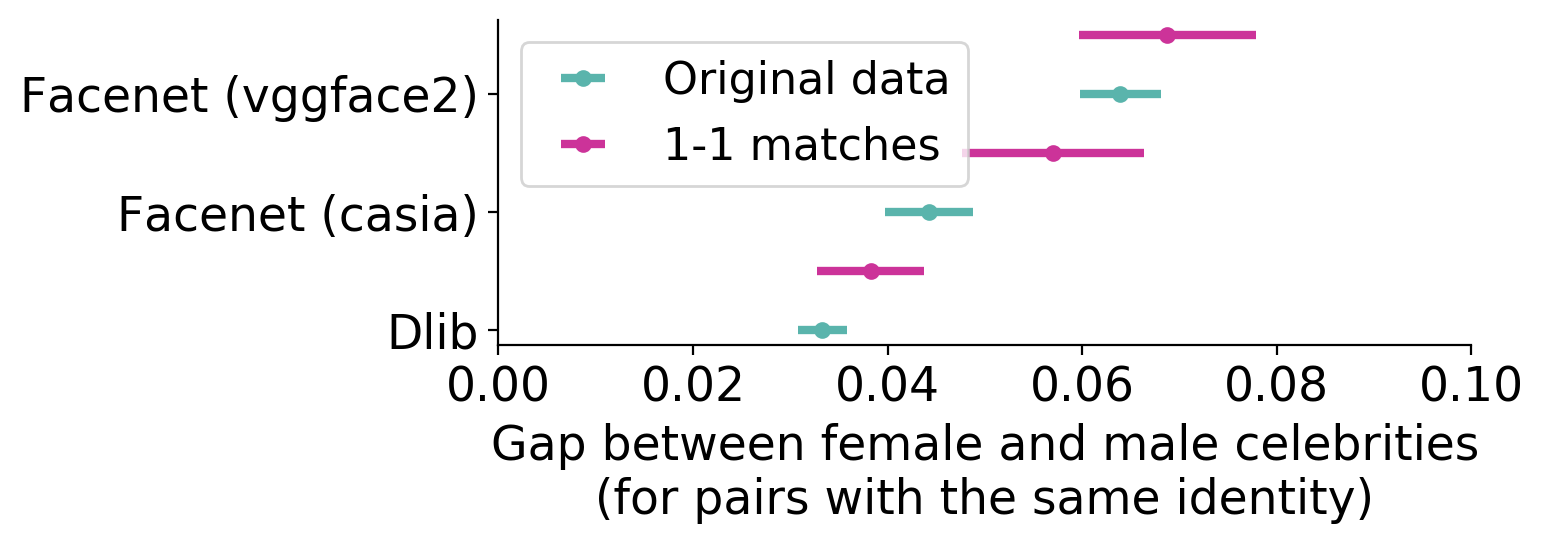

In [32]:
# R, C = 1, 2
fig = plt.figure(dpi=200, figsize=(8, 3))
colors = [cg, cp]
labs = ['Original data', '1-1 matches']
for i, d in enumerate([ds_orig_list, ds_matches_list]):
# for i, d in enumerate([accs_orig_list, accs_matches_list]):    
    g0 = {k: d[k][0] for k in d.keys()}
    g1 = {k: d[k][1] for k in d}
    
    ks = np.array(dist_names)
    means0 = np.array([np.mean(g0[k]) for k in ks])
    means1 = np.array([np.mean(g1[k]) for k in ks])
    args = np.argsort(np.abs(means0 - means1))
     
    lists = [g0[k] for k in ks]
    means0 = np.array([np.mean(l) for l in lists])
    sems0 = np.array([np.std(l) / np.sqrt(l.size) for l in lists])
    lists = [g1[k] for k in ks]
    means1 = np.array([np.mean(l) for l in lists])
    sems1 = np.array([np.std(l) / np.sqrt(l.size) for l in lists])
    ys = np.arange(len(ks))
    plt.errorbar(means0[args] - means1[args], ys + i * 0.5, xerr=sems0, label=labs[i],
                 linestyle='', marker='.', markersize=10, color=colors[i])
#     plt.errorbar(np.zeros(ys.size), ys + i * 0.5, xerr=sems1,
#                  linestyle='', marker='.', markersize=10, color=colors[i])    
    plt.grid(axis='x', which='both')
    
    plt.xlim((0, 0.1))
    plt.yticks(np.arange(len(ks)), [k.capitalize().replace('_', ' ') for k in ks[args]])
plt.xlabel('Gap between female and male celebrities\n(for pairs with the same identity)')
plt.legend()
# plt.legend(bbox_to_anchor=(1, 0.5))
util.savefig('dists_matching')
# plt.legend()    
plt.show()